## Tarea 2

### Prescriptive analytics: Heuristics for Decision-Making

### Wilmar Calderón

#### 201630701

#### Descripción del ejercicio:

Este documento brinda una solución heurísitca constructiva para el caso del ruteo de arcos capacitado (CARP). Este documento busca dar una solución incial para las instancias de Golden et at. (1983) para encontrar una primera solución factible al problema de ruteo.

Como parte de la parametrización del ejercicio, se plantea como condiciones de las rutas propuestas:

1. Todos los vehículos inician en un nodo marcado como *depósito* (_depot_) y vuelven a terminar en este nodo.
2. Si un arco es recorrido una vez (por la $ruta_{i}$) y atiende la demanda, pero después, otra ruta ($ruta_{i+1}$) utiliza este arco para atender su demanda, el costo de recorrer el arco se le asigna a esta ruta ($ruta_{i+1}$).
3. Si un nodo solo se puede conectar por un arco con el depósito, la ruta tendrá el costo de atender la demanda y de volver al origen.
4. Como primera implementación, no se considera la capacidad de los vehículos en la ruta.

Considerando esto, la implementación se plantea en cuatro secciones:
1. Importación de librerías requeridas y previsualización del problema a resolver.
2. Definición de la función de la solución constructiva
3. Lectura de un archivo para obtener los detalles de la red contenida eenna instancia
4. Ejecución de las 23 instancias de Golden et at. (1983)

## 1. Importación de librerías requeridas

In [1209]:
# Importación de librerías utilizadas

import numpy as np #manejo de listas, arreglos y matrices
import re #regular expression: útil para leer facilmente las instancias y obtener la información rápidamente
import os #requerido para la lectura de los archivos .dat de las instancias 
import matplotlib.pyplot as plt #grafica
import networkx as nx #módulo para evaluar grafos, redes, rutas más cortas.
import time #módulo para evalaur el tiempo de ejecución de las soluciones
import random

### 1.1 Previsualización del problema a resolver

Esta sección busca hacer un gráfico inicial de la primera instancia de Golden et at. (1983) para identificar de forma visual el tipo de redes a analizar, así como realizar algunas pruebas y ajustes inciiales, como para las expresiones regulares, que se usarán para la lectura de la información de todas las instancias.

In [1210]:
## PRIMER EJEMPLO: LEE EL ARCHIVO GDB PARA ILUSTRAR EL CASO DE ESTUDIO: CARP EN REDES.
###     En esta sección se ajustaron los detalles de la REGEX para poder leer los detalles de todas las instancias de Golden

# Lee el archivo. En la carpeta en dónde se ejecute el notebook debe estar el archivo
# Cambiar el nombre de la instancia para cambiar el archivo de lectura (pero el archivo de la instancia debe estar en la carpeta)
file_path = os.path.join(os.getcwd(), "gdb1.dat")
with open(file_path, "r") as file:
    texto = file.read()

# Expresión regular para extraer los atributos de los arcos
arcos = {
    (int(n1), int(n2)): [int(c), int(d)]
    for n1, n2, c, d in re.findall(r"\(\s*(\d+),\s*(\d+)\)\s+coste\s+(\d+)\s+demanda\s+(\d+)", texto)
}

# Expresión regular para capturar el número después de "DEPOSITO :"
match = re.search(r"DEPOSITO\s*:\s*(\d+)", texto)
depot=int(match.groups()[0])

# Expresión regular para capturar el número después de "VEHICULOS :"
match1 = re.search(r"VEHICULOS\s*:\s*(\d+)", texto)
veh=int(match1.groups()[0])

# Expresión regular para capturar el número después de "CAPACIDAD :"
match2 = re.search(r"CAPACIDAD\s*:\s*(\d+)", texto)
veh_cap=int(match2.groups()[0])

#Imprime los parámetros 
print("Nodo del Depósito: ", depot)
print("Número de Vehículos: ",veh)
print("Capacidad de cada Vehículo: ",veh_cap)

Nodo del Depósito:  1
Número de Vehículos:  5
Capacidad de cada Vehículo:  5


In [1211]:
# Creación del grafo de ejemplo
G = nx.Graph()

# Agregar nodos y aristas con atributos (basado en el diccionario de atributo de arcos leído del archivo .dat)
for (n1, n2), (coste, demanda) in arcos.items():
    G.add_edge(n1, n2, weight=coste, demanda=demanda)


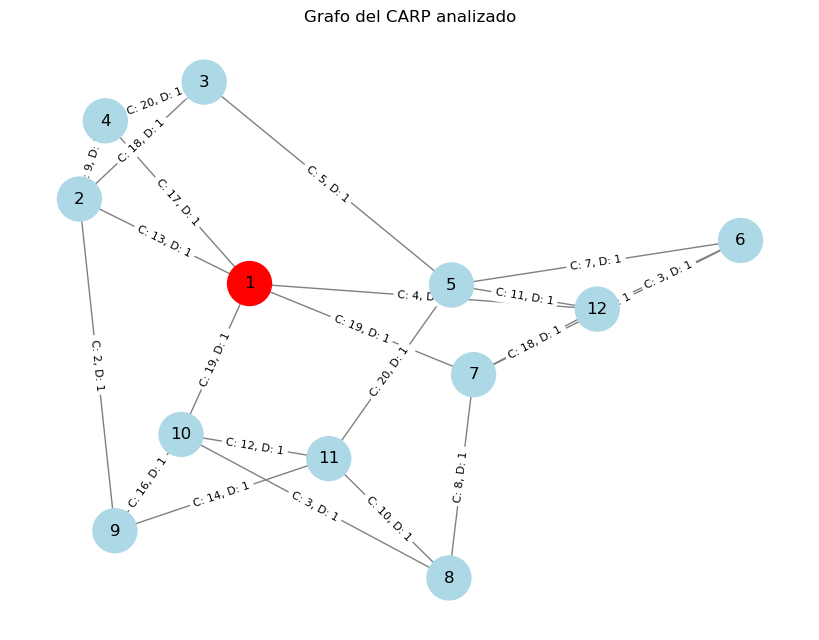

In [1212]:
# Dibujo del Grafo. (como no hay coordenadas de distancia, graficado con la forma de nx.spring_layout)

seed=8 #fija la semilla aleatoria para cualquier cambio de vista (por ejemplo random)
pos = nx.spring_layout(G)  # Carga el gráfico basado en el grafo creado

#Creación de las notas de los arcos
edge_labels = {(n1, n2): f"C: {coste}, D: {demanda}" for (n1, n2), (coste, demanda) in arcos.items()}

plt.figure(figsize=(8, 6))
#Definición de los colores (separa el depósito para visualización)
node_colors = ["red" if node == depot else "lightblue" for node in G.nodes()]
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1000, edge_color='gray', font_size=12)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Grafo del CARP analizado")
plt.show()

In [ ]:

# Step 2: Apply the Ellipse Rule

def filter_edges_by_ellipse(G, node_i,pending_edges,tc,ned,rvc):
    """Filters edges using the ellipse rule."""
    selected_edges = []
    routes= []
    costs= []
    #Get the (j,0) costs
    shortest_paths = nx.single_source_dijkstra_path_length(G, depot, weight="weight")
    #Get the (i,p) costs
    best_nodes=nx.single_source_dijkstra_path_length(G, node_i, weight="weight")
    best_nodes.pop(node_i)
    cost=100000
    for i in pending_edges:
        p=i[0]
        j=i[1]
        if G.has_edge(p, j):
            #Shortest paths to node i 
            SP_vi_vp= best_nodes.get(p, float("inf"))
            c_pj=G[p][j]['weight']
            SP_vj_v0 = shortest_paths.get(j, float("inf"))
            SP_vi_v0 = shortest_paths.get(node_i, float("inf"))
            reference=SP_vi_vp + c_pj + SP_vj_v0
            if (reference <= (tc / ned) + SP_vi_v0) and (rvc-G[p][j]["demanda"]>=0):
                selected_edges.append((p, j))
                routes.append([j,depot])
                costs.append(reference)

                if reference<cost:
                    cost=reference
    return selected_edges,costs,routes

def carp_V2(G,depot,alpha,iter,veh_cap):

    tc = sum(G[u][v]["weight"] for u, v in G.edges())
    td = sum(G[u][v]["demanda"] for u, v in G.edges())
    ned = len(G.edges())

    cost_adj=nx.adjacency_matrix(G,nodelist=range(1,len(G.nodes())+1))
    #costos de salida de esos nodos
    cost_out=cost_adj.todense()

    best_routes=[]
    sol=10000

    rep=0

    while (rep<iter):
        routes=[]
        c_i=0 #cost of i-th route

        pending_edges=list(G.edges())


        nodes_i=[depot] #inicialización de la lista con las rutas
        rvc=veh_cap #definición de la capacidad de cada vehículo
        while len(pending_edges)>0:


            # Filter edges where the first element is the last assigned node
            filtered_edges = [edge for edge in pending_edges if edge[0] == nodes_i[-1] or edge[1]== nodes_i[-1]]

            # Sort the edges based on the second value
            if len(filtered_edges)>0 and nodes_i[-1]!=depot and len(nodes_i)>1:
                sorted_edges = sorted(filtered_edges, key=lambda x: x[1])
                if(rvc-G[sorted_edges[0][0]][sorted_edges[0][1]]["demanda"]<0):
                    i=random.choice(pending_edges)
                else:
                    i=sorted_edges[0]
            else:
                i=random.choice(pending_edges)
            # print("trouble= ",i)
            flag=0
            if (rvc > alpha*td/ned):
                    #get the feasible unserved edges
                F = [(i[1],j+1) for j, val in enumerate(cost_out[i[1]-1]) if val != 0]

                    #remove edges that have already been assigned so F does not include repetition
                if ((i[1],nodes_i[-1]) in F):
                    F.remove((i[1],nodes_i[-1]))
                elif((nodes_i[-1],i[1]) in F):
                    F.remove((nodes_i[-1],i[1]))
            else:
                    F,costs_aux,route_aux=filter_edges_by_ellipse(G, nodes_i[-1],pending_edges,tc,ned,rvc)
                    # print("flag")
                    # print(F)
                    flag=1
            
            if(nodes_i[-1]==depot and len(nodes_i)>1):
                c_a,nods=nx.single_source_dijkstra(G, nodes_i[-1], depot)
                c_i+=c_a
                nodes_i=[depot]
                rvc=veh_cap 


            if (len(F)==0):
                nodes_i.append(depot)
                routes.append(nodes_i)
                nodes_i=[depot]
                rvc=veh_cap            
                c_a,nods=nx.single_source_dijkstra(G, nodes_i[-1], depot)
                c_i+=c_a
            else:
                #represents the first assignation
                if c_i==0:
                    c_i+=G[i[0]][i[1]]["weight"]
                    rvc-=G[i[0]][i[1]]["demanda"]
                    nodes_i.append(i[1])
                    pending_edges.remove((i[0],i[1]))

                p,j=random.choice(F)


                c_i+=G[p][j]["weight"]
                
                if (rvc-G[p][j]["demanda"]<0):
                    c_a,nods=nx.single_source_dijkstra(G, j, depot)
                    c_i+=c_a
                    nodes_i.append(depot)
                else:
                    rvc-=G[p][j]["demanda"]
                    if(p!=nodes_i[-1]): 
                        nodes_i.append(p)
                    nodes_i.append(j)

                    if flag==1:
                        if i in pending_edges:
                            pending_edges.remove((p,j))
                        idx=F.index((p,j))
                        c_i+=costs_aux[idx]
                        nodes_i.extend(route_aux[idx])         

                    F_i=(p,j)
                    if F_i in pending_edges:
                        pending_edges.remove(F_i)
                    if (F_i[1],F_i[0]) in pending_edges:
                        pending_edges.remove((F_i[1],F_i[0]))

                # print("route: ",nodes_i)
                # print("costo: ",c_i)
                # print("attended demand: ",veh_cap-rvc)
        if(c_i<sol and len(pending_edges)==0 and c_i>td):
            best_routes.append(routes)
            sol=c_i

        rep+=1
    return(sol,len(pending_edges),best_routes[-1],td)

### 3. Lectura de un archivo para obtener los detalles de la red contenida eenna instancia


In [ ]:
def archivo_ejec(filename):
    # Lee el archivo. En la carpeta en dónde se ejecute el notebook debe estar el archivo
    # Cambiar el nombre de la instancia para cambiar el archivo de lectura (pero el archivo de la instancia debe estar en la carpeta)
    file_path = os.path.join(os.getcwd(), filename+".dat")
    with open(file_path, "r") as file:
        texto = file.read()

    # Expresión regular para extraer los arcos
    arcos = {
        (int(n1), int(n2)): [int(c), int(d)]
        for n1, n2, c, d in re.findall(r"\(\s*(\d+),\s*(\d+)\)\s+coste\s+(\d+)\s+demanda\s+(\d+)", texto)
    }

    # Expresión regular para capturar el número después de "DEPOSITO :"
    match = re.search(r"DEPOSITO\s*:\s*(\d+)", texto)
    depot_i=int(match.groups()[0])

    # Expresión regular para capturar el número después de "CAPACIDAD :"
    match2 = re.search(r"CAPACIDAD\s*:\s*(\d+)", texto)
    veh_cap=int(match2.groups()[0])


    # Creación del grafo 
    G = nx.Graph()


    # Agregar nodos y aristas con atributos (basado en el diccionario de atributo de arcos leído del archivo .dat)
    for (n1, n2), (coste, demanda) in arcos.items():
        G.add_edge(n1, n2, weight=coste, demanda=demanda)

    alpha =2.5  # Adjust this value based on clustering behavior
    iter=5000
 
    c_t,len1,rt_i,d_i=carp_V2(G,depot_i,alpha,iter,veh_cap)

    if(len1==0):
        
        print("\n PARA LA INSTANCIA "+filename+": \n")
        print("¡Se asignaron correctamente todas las rutas!")
        print("A un costo de:")
        print(c_t)
        print("\n con respecto a la solución: \n")
        print("se atendió la siguiente demanda: ",d_i)
        print("se mediante el siguiente número de rutas: ",len(rt_i))
    return c_t

### 4. Ejecución de las 23 instancias de Golden et at. (1983)

In [1215]:
costs=np.zeros([23,3])

for i in range(1,24):
    filename="gdb"+str(i)
    start_time = time.time()
    c_i=archivo_ejec(filename)
    finish_time = time.time()
    costs[i-1,0]=int(i)
    costs[i-1,1]=int(c_i)
    costs[i-1,2]=finish_time-start_time




 PARA LA INSTANCIA gdb1: 

¡Se asignaron correctamente todas las rutas!
A un costo de:
319

 con respecto a la solución: 

se atendió la siguiente demanda:  22
se mediante el siguiente número de rutas:  6

 PARA LA INSTANCIA gdb2: 

¡Se asignaron correctamente todas las rutas!
A un costo de:
397

 con respecto a la solución: 

se atendió la siguiente demanda:  26
se mediante el siguiente número de rutas:  8

 PARA LA INSTANCIA gdb3: 

¡Se asignaron correctamente todas las rutas!
A un costo de:
295

 con respecto a la solución: 

se atendió la siguiente demanda:  22
se mediante el siguiente número de rutas:  8

 PARA LA INSTANCIA gdb4: 

¡Se asignaron correctamente todas las rutas!
A un costo de:
285

 con respecto a la solución: 

se atendió la siguiente demanda:  19
se mediante el siguiente número de rutas:  6

 PARA LA INSTANCIA gdb5: 

¡Se asignaron correctamente todas las rutas!
A un costo de:
396

 con respecto a la solución: 

se atendió la siguiente demanda:  26
se mediante el 

In [1216]:
import pandas as pd

## convert your array into a dataframe
df = pd.DataFrame (costs,columns=["Instance","Cost","CPU Time(s)"])

## save to xlsx file

filepath = 'resultsV2.xlsx'

df.to_excel(filepath, index=False)

### Si desea correr una instancia, simplemente seleccione el número de la instancia que desea evaluar:

(modifique el número en la línea que define a "filename")

In [1217]:
# #Nodifique abajo (cambie 1 por la que usted desee)
# filename="gdb"+str(1)
# c_i=archivo_ejec(filename)
# print("Costo de recorrer la instancia ",c_i)